In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torch
import lightning.pytorch as pl
from src.model.full_model import SubCellProtModel
from src.utils.analysis_utils import call_model
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns


In [3]:
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    batch_size=32,
)

number of classes  29
number of classes  29


In [4]:
from pymongo import MongoClient
from src.utils.utils import get_data_path
import pickle 

COLLECTION_NAME = "splice_isoforms"
X_landmark_stains = None
if os.path.exists('proteoform_activation.csv'):
    new_activation_roundup_df= pd.read_csv('proteoform_activation.csv')
else:
    new_activation_roundup_df= pd.DataFrame()

limit = 100000

save_cadence = 200
rest_cadence = 100

In [8]:
import time

with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]

    # Get all documents in the collection
    cursor = dataset_collection.find()

    for idx, document in tqdm(enumerate(cursor)):
        if idx % rest_cadence == 0:
            time.sleep(0.1)

        if document["_id"] in new_activation_roundup_df["Proteoform"]:
            continue

        try:
            X_esm2_encoding = pickle.loads(document["esm2_representation"]["binary"])
            X_protein_len = document["length"]
            localization_labels = document["cell_lines"][0]["antibodies"][0][
                "location_labels"
            ]["locations"]
            localization_labels = localization_labels.split(",")
            if X_landmark_stains is None:
                X_landmark_stains = np.stack(
                    (
                        np.array(
                            Image.open(
                                get_data_path(
                                    document["cell_lines"][0]["antibodies"][0][
                                        "image_urls"
                                    ][0]["cell_images"][0]["nuclei_channel"]
                                )
                            )
                        ),
                        np.array(
                            Image.open(
                                get_data_path(
                                    document["cell_lines"][0]["antibodies"][0][
                                        "image_urls"
                                    ][0]["cell_images"][0]["microtubule_channel"]
                                )
                            )
                        ),
                        np.array(
                            Image.open(
                                get_data_path(
                                    document["cell_lines"][0]["antibodies"][0][
                                        "image_urls"
                                    ][0]["cell_images"][0]["mitochondria_channel"]
                                )
                            )
                        ),
                    )
                )
            _y_pred_ranked, _y_pred_antibody_stain, activation = call_model(
                loaded_model,
                X_esm2_encoding,
                X_protein_len,
                X_landmark_stains,
                embedding_hooks=["protein_embedding"],
            )
            new_activation_roundup_df = new_activation_roundup_df._append(
                {
                    "Proteoform": document["_id"],
                    "Activation": np.array(activation["protein_embedding"]),
                    "Localization": localization_labels,
                },
                ignore_index=True,
            )

            if limit % save_cadence == 0:
                new_activation_roundup_df.to_csv(
                    "proteoform_activation.csv"
                )
                print("saved!: ", limit)
                time.sleep(
                    0.5
                )  

        except:
            continue

        limit -= 1
        if limit <= 0:
            break
new_activation_roundup_df.to_csv(
    "proteoform_activation.csv"
)

11383it [02:40, 81.72it/s]

saved!:  100000


11612it [02:54, 16.66it/s]

saved!:  99800


11822it [03:08, 17.02it/s]

saved!:  99600


12038it [03:22, 17.69it/s]

saved!:  99400


12280it [03:38, 20.87it/s]

saved!:  99200


12499it [03:54, 20.93it/s]

saved!:  99000


12739it [04:10, 13.64it/s]

saved!:  98800


12957it [04:26, 16.84it/s]

saved!:  98600


13180it [04:42, 16.92it/s]

saved!:  98400


13395it [04:57, 18.11it/s]

saved!:  98200


13619it [05:15, 17.24it/s]

saved!:  98000


13844it [05:31, 15.72it/s]

saved!:  97800


14058it [05:48, 19.18it/s]

saved!:  97600


14293it [06:06, 17.67it/s]

saved!:  97400


14524it [06:23, 12.38it/s]

saved!:  97200


14751it [06:41, 17.91it/s]

saved!:  97000


14975it [06:58, 16.22it/s]

saved!:  96800


15198it [07:16, 17.96it/s]

saved!:  96600


15418it [07:34, 17.97it/s]

saved!:  96400


15640it [07:53, 16.90it/s]

saved!:  96200


15866it [08:12, 15.46it/s]

saved!:  96000


16088it [08:31, 16.28it/s]

saved!:  95800


16313it [08:51, 14.26it/s]

saved!:  95600


16590it [09:12, 18.29it/s]

saved!:  95400


16804it [09:32, 14.32it/s]

saved!:  95200


17040it [09:53, 16.40it/s]

saved!:  95000


17259it [10:14, 15.20it/s]

saved!:  94800


17483it [10:35, 16.36it/s]

saved!:  94600


17712it [10:57, 13.82it/s]

saved!:  94400


17930it [11:18, 17.80it/s]

saved!:  94200


18152it [11:40, 15.36it/s]

saved!:  94000


18394it [12:02, 23.38it/s]

saved!:  93800


18627it [12:24, 19.05it/s]

saved!:  93600


18851it [12:46, 15.81it/s]

saved!:  93400


19073it [13:09, 14.46it/s]

saved!:  93200


19300it [13:32, 18.44it/s]

saved!:  93000


19513it [13:56, 15.06it/s]

saved!:  92800


19758it [14:20, 19.74it/s]

saved!:  92600


19985it [14:43, 17.41it/s]

saved!:  92400


20209it [15:07, 15.07it/s]

saved!:  92200


20458it [15:32, 16.60it/s]

saved!:  92000


20666it [15:55, 13.29it/s]

saved!:  91800


20901it [16:20, 14.74it/s]

saved!:  91600


21109it [16:45, 14.32it/s]

saved!:  91400


21330it [17:10, 14.18it/s]

saved!:  91200


21544it [17:36, 13.35it/s]

saved!:  91000


21765it [18:01, 15.14it/s]

saved!:  90800


21999it [18:28, 15.46it/s]

saved!:  90600


22215it [18:54, 12.94it/s]

saved!:  90400


22449it [19:21, 16.33it/s]

saved!:  90200


22703it [19:48, 13.62it/s]

saved!:  90000


22925it [20:16, 12.17it/s]

saved!:  89800


23145it [20:43, 14.33it/s]

saved!:  89600


23368it [21:10, 14.92it/s]

saved!:  89400


23604it [21:38, 16.05it/s]

saved!:  89200


23824it [22:18, 17.59it/s]

saved!:  89000


24040it [22:35, 13.64it/s]

saved!:  88800


24251it [23:03, 15.37it/s]

saved!:  88600


24463it [23:31, 13.08it/s]

saved!:  88400


24687it [24:02, 13.76it/s]

saved!:  88200


24899it [24:31, 13.40it/s]

saved!:  88000


25123it [25:01, 13.66it/s]

saved!:  87800


25352it [25:30, 13.58it/s]

saved!:  87600


25588it [26:00, 14.36it/s]

saved!:  87400


25815it [26:30, 14.57it/s]

saved!:  87200


26022it [27:01, 12.84it/s]

saved!:  87000


26240it [27:31, 14.21it/s]

saved!:  86800


26464it [28:02, 13.41it/s]

saved!:  86600


26682it [28:33, 14.89it/s]

saved!:  86400


26903it [29:18, 11.06it/s]

saved!:  86200


27127it [29:49, 14.54it/s]

saved!:  86000


27346it [30:19, 15.09it/s]

saved!:  85800


27577it [30:42, 14.52it/s]

saved!:  85600


27809it [31:29, 14.55it/s]

saved!:  85400


28034it [31:59, 25.34it/s]

saved!:  85200


28287it [32:22, 21.11it/s]

saved!:  85000


28504it [33:10, 11.90it/s]

saved!:  84800


28736it [33:40, 13.45it/s]

saved!:  84600


28945it [34:20, 13.56it/s]

saved!:  84400


29166it [34:50,  9.65it/s]

saved!:  84200


29401it [35:11, 11.94it/s]

saved!:  84000


29620it [36:00, 12.54it/s]

saved!:  83800


29833it [36:22, 11.49it/s]

saved!:  83600


30061it [37:10, 13.80it/s]

saved!:  83400


30273it [37:50, 13.57it/s]

saved!:  83200


30514it [38:20, 13.17it/s]

saved!:  83000


30732it [39:01, 14.59it/s]

saved!:  82800


30954it [39:21, 14.05it/s]

saved!:  82600


31173it [40:11, 11.64it/s]

saved!:  82400


31392it [40:51, 12.83it/s]

saved!:  82200


31604it [41:31, 10.32it/s]

saved!:  82000


31825it [42:01, 12.78it/s]

saved!:  81800


32045it [42:41, 13.06it/s]

saved!:  81600


32283it [43:21, 13.08it/s]

saved!:  81400


32523it [44:01, 12.93it/s]

saved!:  81200


32757it [44:41, 12.51it/s]

saved!:  81000


32981it [45:11, 11.47it/s]

saved!:  80800


33196it [45:51, 11.64it/s]

saved!:  80600


33419it [46:31, 11.90it/s]

saved!:  80400


33661it [47:11, 12.27it/s]

saved!:  80200


33873it [47:51, 11.95it/s]

saved!:  80000


34090it [48:32, 14.03it/s]

saved!:  79800


34320it [49:12, 12.27it/s]

saved!:  79600


34547it [49:52, 12.10it/s]

saved!:  79400


34777it [50:32, 11.56it/s]

saved!:  79200


34991it [51:12, 17.96it/s]

saved!:  79000


35210it [51:52, 11.45it/s]

saved!:  78800


35428it [52:42, 11.22it/s]

saved!:  78600


35670it [53:22, 11.17it/s]

saved!:  78400


35893it [54:02, 10.94it/s]

saved!:  78200


36108it [54:43, 10.28it/s]

saved!:  78000


36360it [55:33, 13.31it/s]

saved!:  77800


36586it [56:13, 10.79it/s]

saved!:  77600


36793it [56:53, 10.57it/s]

saved!:  77400


37048it [57:43, 11.01it/s]

saved!:  77200


37272it [58:23, 11.11it/s]

saved!:  77000


37511it [58:55,  9.12it/s]

saved!:  76800


37734it [59:53, 10.88it/s]

saved!:  76600


37976it [1:00:43, 12.35it/s]

saved!:  76400


38196it [1:01:24, 14.14it/s]

saved!:  76200


38408it [1:02:14, 11.20it/s]

saved!:  76000


38635it [1:02:54, 11.51it/s]

saved!:  75800


38851it [1:03:45, 11.17it/s]

saved!:  75600


39079it [1:04:25, 14.13it/s]

saved!:  75400


39295it [1:05:15, 11.52it/s]

saved!:  75200


39514it [1:05:55, 11.31it/s]

saved!:  75000


39745it [1:06:45, 11.58it/s]

saved!:  74800


39955it [1:07:36, 12.43it/s]

saved!:  74600


40186it [1:08:16, 11.59it/s]

saved!:  74400


40409it [1:09:06, 11.36it/s]

saved!:  74200


40633it [1:09:56, 10.58it/s]

saved!:  74000


40766it [1:10:19,  9.66it/s]


In [2]:
import pandas as pd
new_activation_roundup_df = pd.read_csv('proteoform_activation.csv')
new_activation_roundup_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Proteoform,Activation,Localization
0,0,0.0,0.0,TSPAN6-201,[[ 0.1814981 -0.20387764 -1.1932619 -1.27473...,"['Cell Junctions', 'Cytosol', 'Nucleoli fibril..."
1,1,1.0,1.0,TSPAN6-204,[[ 0.1814981 -0.20387764 -1.1932619 -1.27473...,"['Cell Junctions', 'Cytosol', 'Nucleoli fibril..."
2,2,2.0,2.0,TSPAN6-205,[[ 0.1814981 -0.20387764 -1.1932619 -1.27473...,"['Cell Junctions', 'Cytosol', 'Nucleoli fibril..."
3,3,3.0,3.0,SCYL3-201,[[ 0.1814981 -0.20387764 -1.1932619 1.91370...,['Microtubules']
4,4,4.0,4.0,SCYL3-202,[[ 0.1814981 -0.20387764 -1.1932619 1.88251...,['Microtubules']
...,...,...,...,...,...,...
40617,40617,NaN,NaN,NME1-204,[[ 1.8149810e-01 -2.0387764e-01 -3.4338468e-01...,['No staining']
40618,40618,NaN,NaN,NME1-207,[[ 0.1814981 -0.20387764 -0.03841972 -0.76753...,['No staining']
40619,40619,NaN,NaN,POU5F1B-201,[[ 0.1814981 -0.20387764 -0.28596672 -0.34517...,['Nucleoplasm']
40620,40620,NaN,NaN,POU5F1B-202,[[ 0.1814981 -0.20387764 -0.28596672 -0.34517...,['Nucleoplasm']


In [4]:
import re
import numpy as np
import ast

def parse_expression(expression_str):
    expression_str = expression_str.replace('[ ', '[').replace(' ]', ']')
    expression_str = re.sub(r'\s+', ' ', expression_str).strip()    
    return np.array(ast.literal_eval(expression_str.replace(' ', ',')))

new_activation_roundup_df['Activation'] = new_activation_roundup_df['Activation'].apply(parse_expression)
new_activation_roundup_df['Localization'] = new_activation_roundup_df['Localization'].apply(ast.literal_eval)
new_activation_roundup_df


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Proteoform,Activation,Localization
0,0,0.0,0.0,TSPAN6-201,"[[0.1814981, -0.20387764, -1.1932619, -1.27473...","[Cell Junctions, Cytosol, Nucleoli fibrillar c..."
1,1,1.0,1.0,TSPAN6-204,"[[0.1814981, -0.20387764, -1.1932619, -1.27473...","[Cell Junctions, Cytosol, Nucleoli fibrillar c..."
2,2,2.0,2.0,TSPAN6-205,"[[0.1814981, -0.20387764, -1.1932619, -1.27473...","[Cell Junctions, Cytosol, Nucleoli fibrillar c..."
3,3,3.0,3.0,SCYL3-201,"[[0.1814981, -0.20387764, -1.1932619, 1.913707...",[Microtubules]
4,4,4.0,4.0,SCYL3-202,"[[0.1814981, -0.20387764, -1.1932619, 1.882519...",[Microtubules]
...,...,...,...,...,...,...
40617,40617,NaN,NaN,NME1-204,"[[0.1814981, -0.20387764, -0.34338468, 0.07599...",[No staining]
40618,40618,NaN,NaN,NME1-207,"[[0.1814981, -0.20387764, -0.03841972, -0.7675...",[No staining]
40619,40619,NaN,NaN,POU5F1B-201,"[[0.1814981, -0.20387764, -0.28596672, -0.3451...",[Nucleoplasm]
40620,40620,NaN,NaN,POU5F1B-202,"[[0.1814981, -0.20387764, -0.28596672, -0.3451...",[Nucleoplasm]


In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca_results = pca.fit_transform(np.array([np.array(np.squeeze(x)) for x in new_activation_roundup_df['Activation'].to_numpy()]))
print("PCA explained variances:", pca.explained_variance_ratio_)
print("PCA explained variance sum: ", sum(pca.explained_variance_ratio_))

new_activation_roundup_df['PC 1'] = pca_results[:, 1]
new_activation_roundup_df['PC 2'] = pca_results[:, 2]

PCA explained variances: [9.99770335e-01 2.99990998e-05 2.34480594e-05 1.84115573e-05
 1.70064036e-05 1.29689871e-05 1.09095927e-05 9.68882599e-06
 8.97314972e-06 8.16401367e-06 7.43908255e-06 6.15662183e-06
 5.43325594e-06 5.31730709e-06 5.17749836e-06 4.45306899e-06
 4.23492480e-06 3.68511241e-06 3.36093397e-06 3.26262793e-06
 3.01680819e-06 2.54586852e-06 2.34469587e-06 2.21877117e-06
 2.12984138e-06 2.05803737e-06 1.89965586e-06 1.76134490e-06
 1.71310436e-06 1.52531783e-06 1.40992762e-06 1.35794858e-06
 1.33527260e-06 1.18314974e-06 1.13364512e-06 1.11043023e-06
 1.06703158e-06 9.06834106e-07 8.78428349e-07 8.37742797e-07
 8.16123534e-07 7.67481990e-07 7.10710713e-07 6.77582933e-07
 6.56599255e-07 6.36402370e-07 5.87242904e-07 5.65090513e-07
 5.27247176e-07 4.66342804e-07 4.46359799e-07 4.39749618e-07
 4.21552748e-07 4.05371339e-07 3.19505836e-07 2.89955284e-07
 1.76101099e-07 1.27003656e-07 7.89159709e-08 2.55356494e-08
 8.79397770e-22 2.13595878e-22 4.79102510e-28 6.29500341e-32

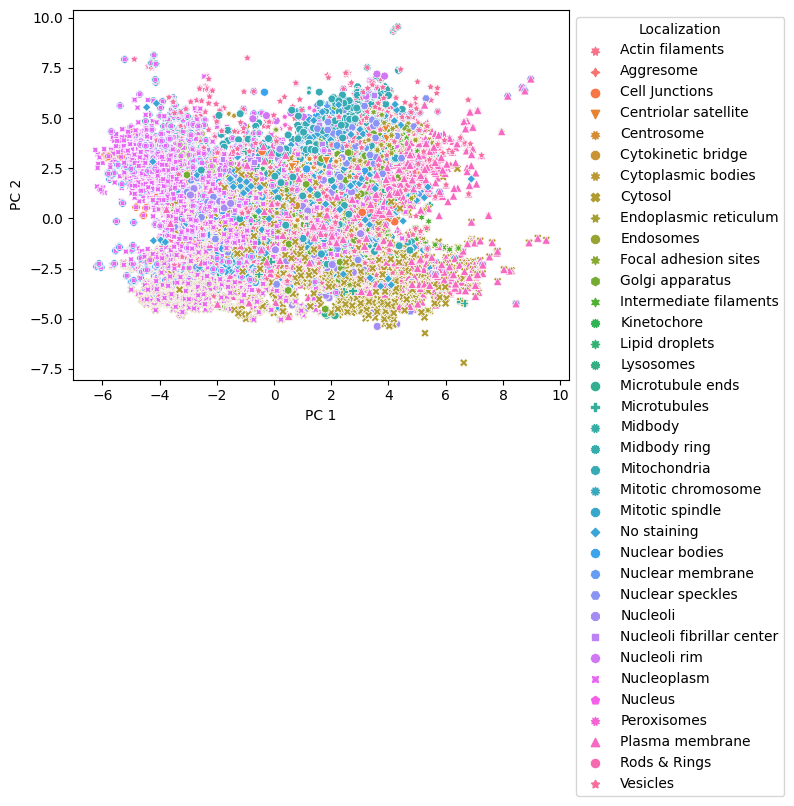

In [8]:
exploded_activation_roundup_df = new_activation_roundup_df.explode('Localization')
f = plt.figure()

hue_order = sorted(list(set(exploded_activation_roundup_df['Localization'])))

ax = sns.scatterplot(
    data=exploded_activation_roundup_df,
    x='PC 1',
    y='PC 2',
    style='Localization',
    hue='Localization',
    hue_order=hue_order
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
f.savefig("all_proteoform_pca.pdf", bbox_inches='tight')


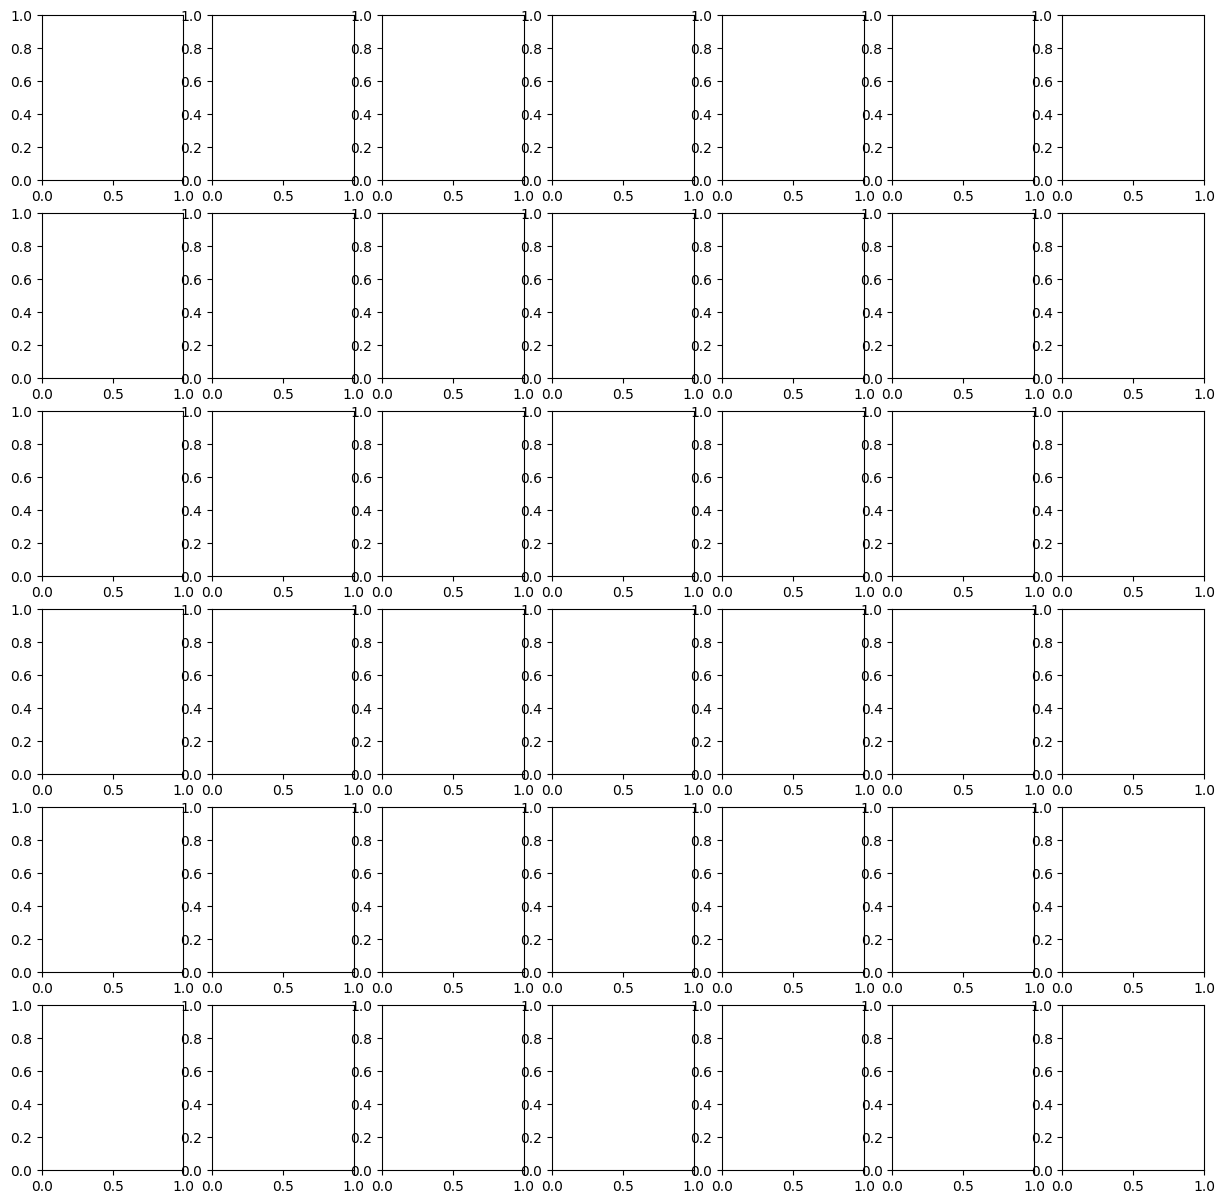

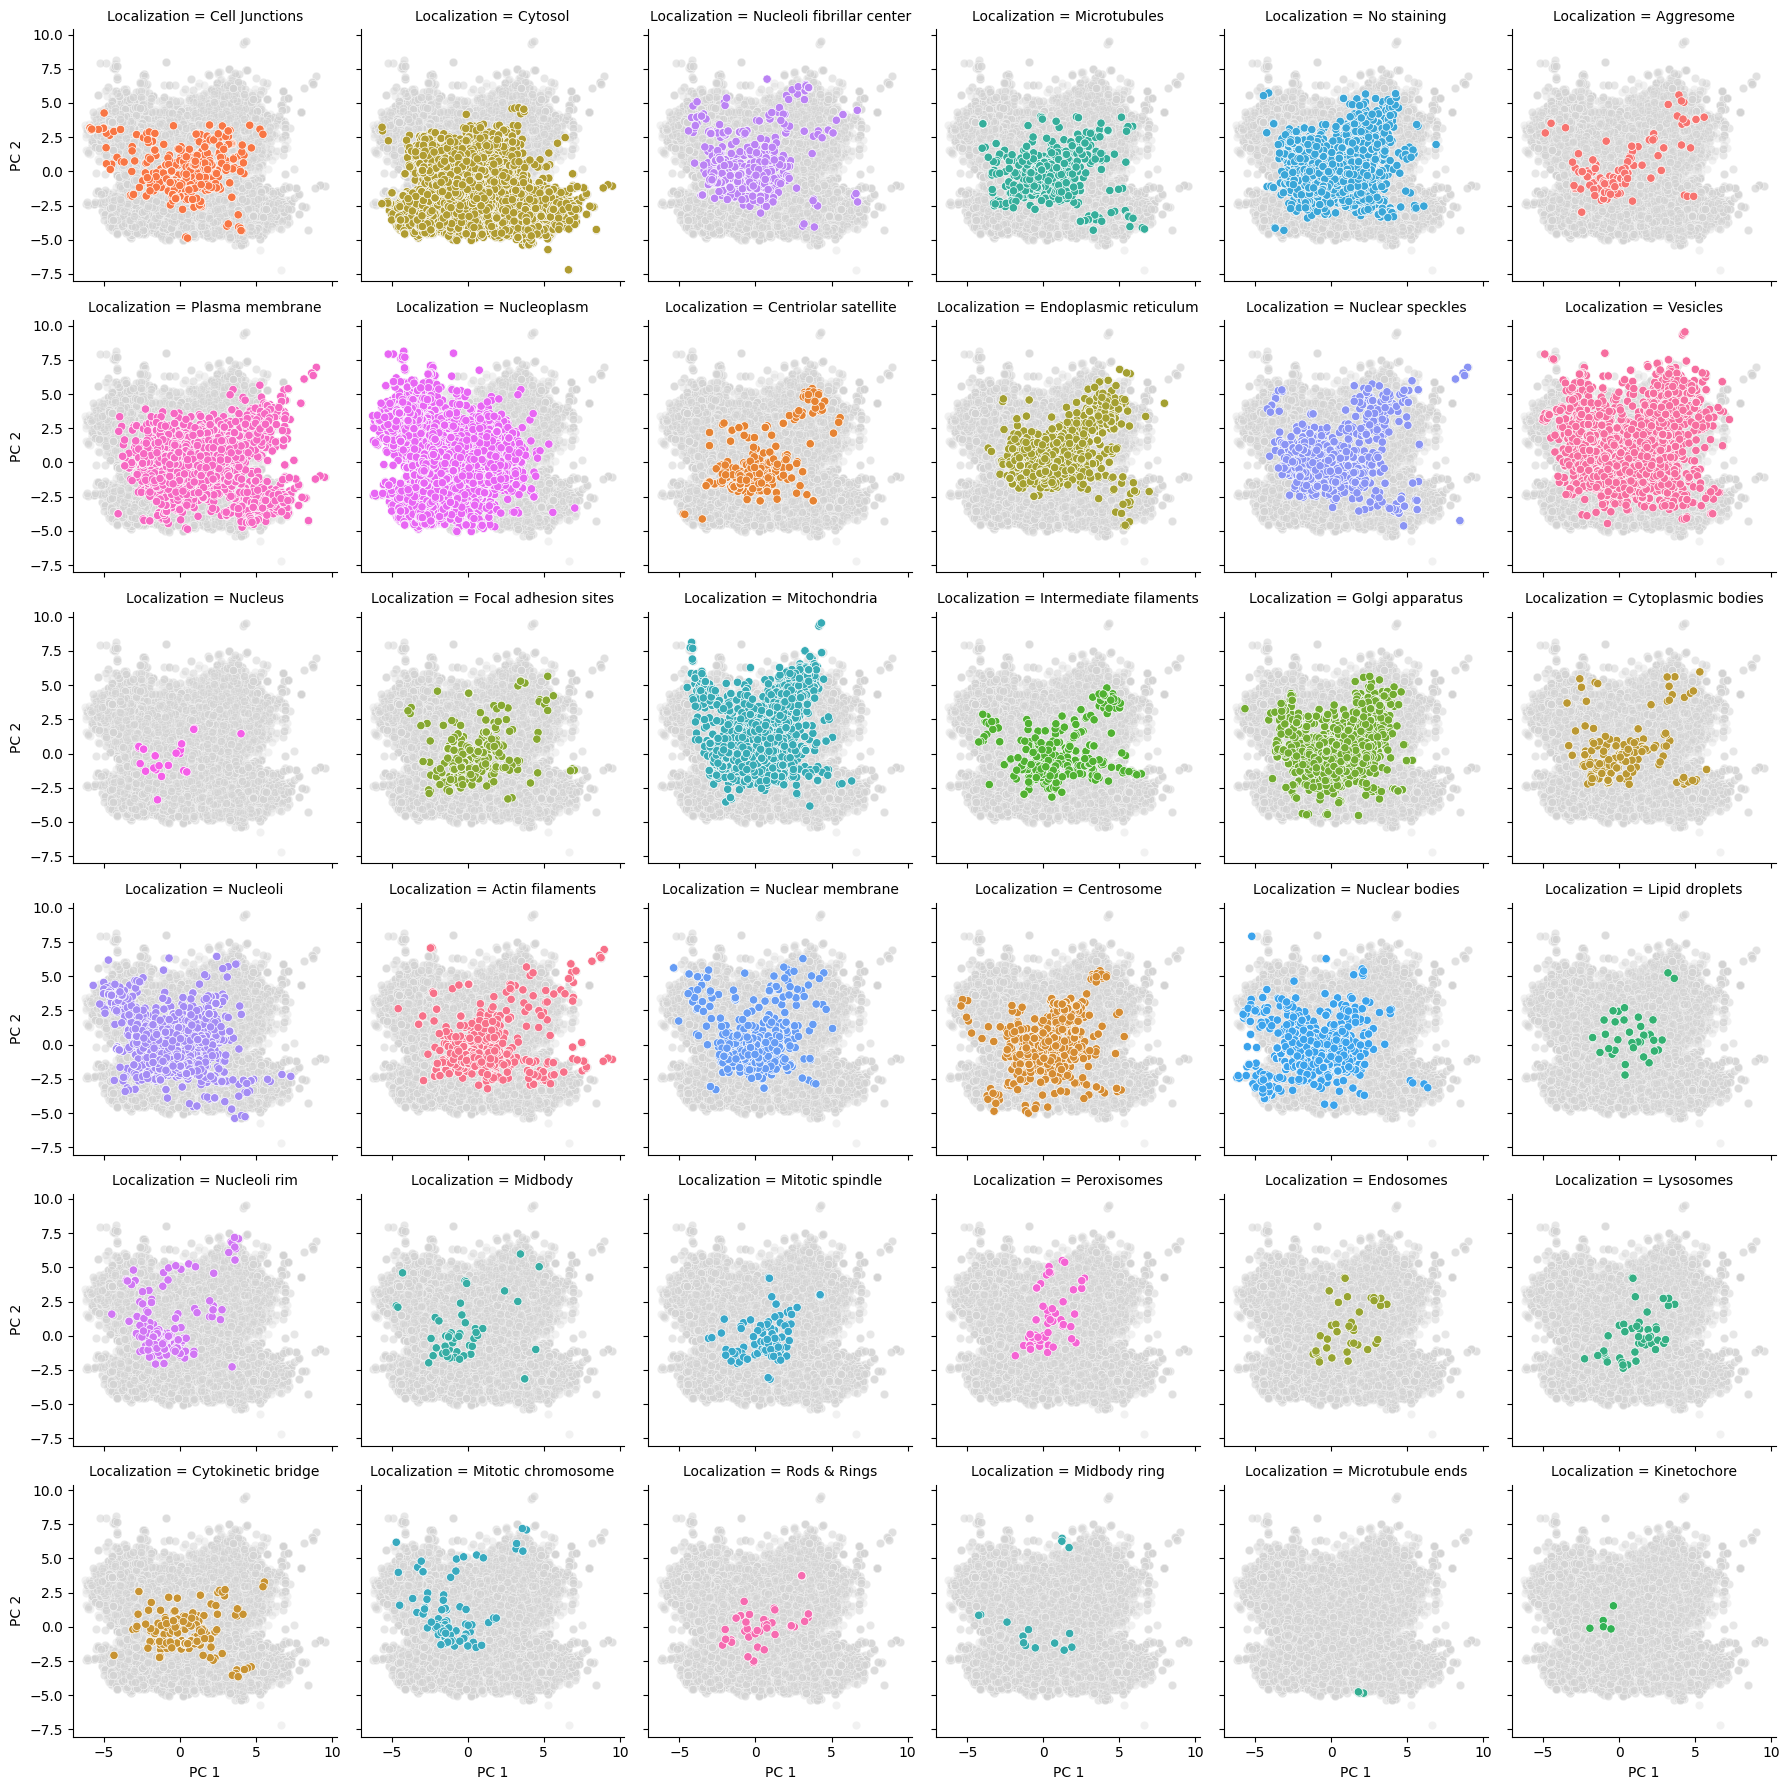

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(6, 7, figsize=(15, 15)) 

g = sns.FacetGrid(
    exploded_activation_roundup_df, 
    col='Localization', 
    col_wrap=6,
)

def plot_grey_background(data, color, **kwargs):
    sns.scatterplot(
        x='PC 1',
        y='PC 2',
        data=exploded_activation_roundup_df,
        color='lightgrey',  
        ax=plt.gca(), 
        alpha=0.3, 
    )

g.map_dataframe(plot_grey_background)

g.map_dataframe(
    sns.scatterplot,
    x='PC 1',
    y='PC 2',
    hue='Localization',
    style='Localization',
    hue_order=hue_order,
    ax=plt.gca()
)

plt.tight_layout()

g.savefig("all_proteoform_pca_exploded.pdf", bbox_inches='tight')

plt.show()
